# SHAP sample plot experiments with brief explanations

The structure of this notebook is very closely aligned to https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html 

However, we use data and model from fortunate_training.py which is relevant for the final application. 

In [139]:
import pandas as pd
import pickle
import shap
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

We are loading the XGBClassifier model trained in fortunate_training.py and the data preprocessed also in fortunate_training.py. 

To save computation time, we take a subset of this data.

In [140]:
with open("models/fortunate_loan_model_gpu.pkl", "rb") as file:
    model = pickle.load(file)

data = pd.read_csv("data/loan_data_preprocessed.csv")
data.replace({False: 0, True: 1}, inplace=True)
data100 = shap.utils.sample(data, 2000)

/home/bytep/anaconda3/envs/twelve/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/home/bytep/anaconda3/envs/twelve/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/home/bytep/anaconda3/envs/twelve/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:07:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarnin

In [141]:
data100.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
17937,28.0,1,2,74454.0,6,0,25000.0,9.91,0.34,7.0,692,0,0,0,0,0,1,0
22168,30.0,0,3,65631.0,8,1,9600.0,11.01,0.15,8.0,732,1,0,0,0,0,0,1
1694,22.0,1,2,36012.0,0,1,11500.0,11.01,0.32,3.0,550,1,0,0,0,0,0,1
27443,29.0,1,1,164252.0,9,1,7775.0,14.96,0.05,5.0,647,0,1,0,0,0,0,0
34871,30.0,1,1,95971.0,9,1,14968.0,11.04,0.16,7.0,606,0,0,0,0,0,0,1


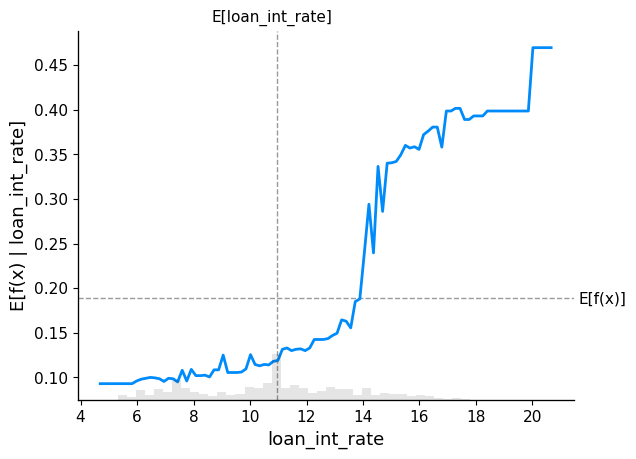

In [142]:
shap.partial_dependence_plot(
    "loan_int_rate",
    model.predict,
    data100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Above is the **dependence plot** containing a histogram (so 2 plots to be precise).


- The x-axis should show the applied interest rate on the bank loan. 
- The y-axis shows the result prediction (0 = loan not approved, 1 = loan approved).
- The blue line shows the averaged result prediction for each interest rate value.
- The absolute height of the grey bars is irrelevant. But their relative height to each other shows how often a particular interval of interest rates appears in the dataset.
- The grey vertical line shows the expected interest rate (11% since this is the most common rate).
- The grey horizontal line shows the expected prediction value.

The interest rate has in general a positive effect on the prediction after it crosses the grey horizontal line (interest rate of 14%). The higher the interest rate, the more likely a bank is willing to approve a loan.

Computing **SHAP values** is fairly easy with this library.

The key idea stems from game theory. Imagine a group project with 8 people. We want to fairly reward these people for their contributions to the project. How do we find out, how well each person contributed to the project? We can simulate the project outcome with initially 0 people. Then we add 1 person and calculate the result again. Then a second person... until we have the final result with all 8 people. The differences between these incremental steps show then how much a person contributed to the final result (and whether it was positive or even negative!).

Now transfer this idea towards machine learning: replace "people" with "features" and "project outcome" with "model prediction". Voila!

The explainer was just initialized (0 features), and its expected value of -1.34 is now the base.

In [154]:
# compute the SHAP values for the linear model
explainer = shap.TreeExplainer(model)
shap_values = explainer(data100)
explainer.expected_value

-1.3404719

In [155]:
shap_values.values

array([[ 0.01396282, -0.02586108, -0.01621743, ..., -0.06871799,
        -0.02179516,  0.08154413],
       [ 0.0581499 , -0.02155812,  0.0261408 , ..., -0.04231413,
         0.00236881, -0.22802374],
       [ 0.05965595, -0.01059812, -0.06654523, ..., -0.03007603,
        -0.00465691, -0.22629723],
       ...,
       [ 0.07860529,  0.00774646,  0.00699658, ..., -0.03357503,
        -0.00770273,  0.08145448],
       [-0.0132558 , -0.00403114, -0.06632536, ..., -0.02331008,
        -0.00912353,  0.0276135 ],
       [ 0.12634282,  0.03115831,  0.09684038, ..., -0.03882535,
        -0.01526496, -0.26165986]], dtype=float32)

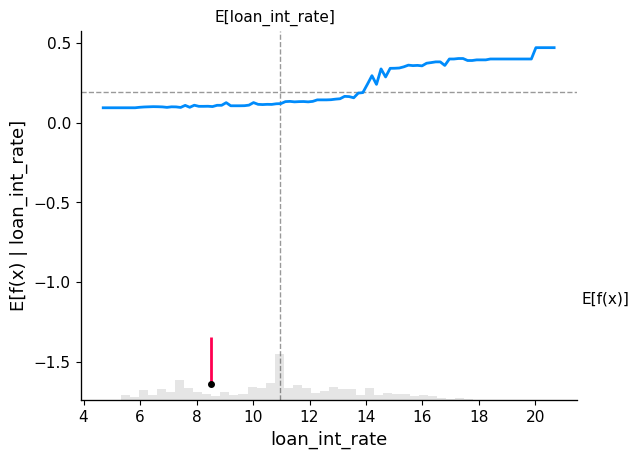

In [144]:


# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "loan_int_rate",
    model.predict,
    data100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

The shap value of a feature (i.e. of interest rate) is (expected model output minus partial dependence).

In this case we have a interest rate of approximately 8.5%, therefore the partial dependence should be around 0.11. -1.34 - 0.11 should roughly be -1.45

The red line on the graph is confusing.

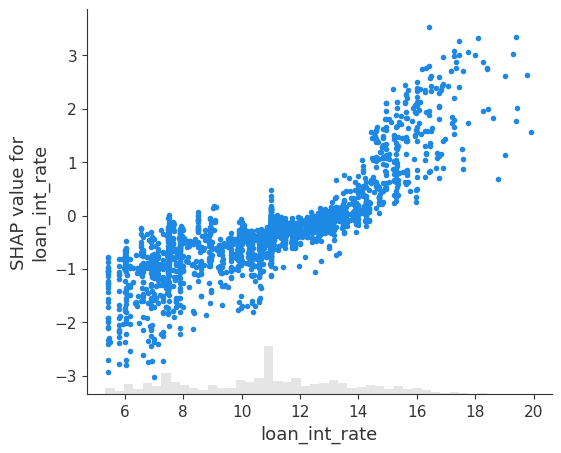

In [145]:
shap.plots.scatter(shap_values[:, "loan_int_rate"])

Above, the real shap values are displayed. We can see that after the interest rate reaches 14%, the impact on model prediction becomes positive.

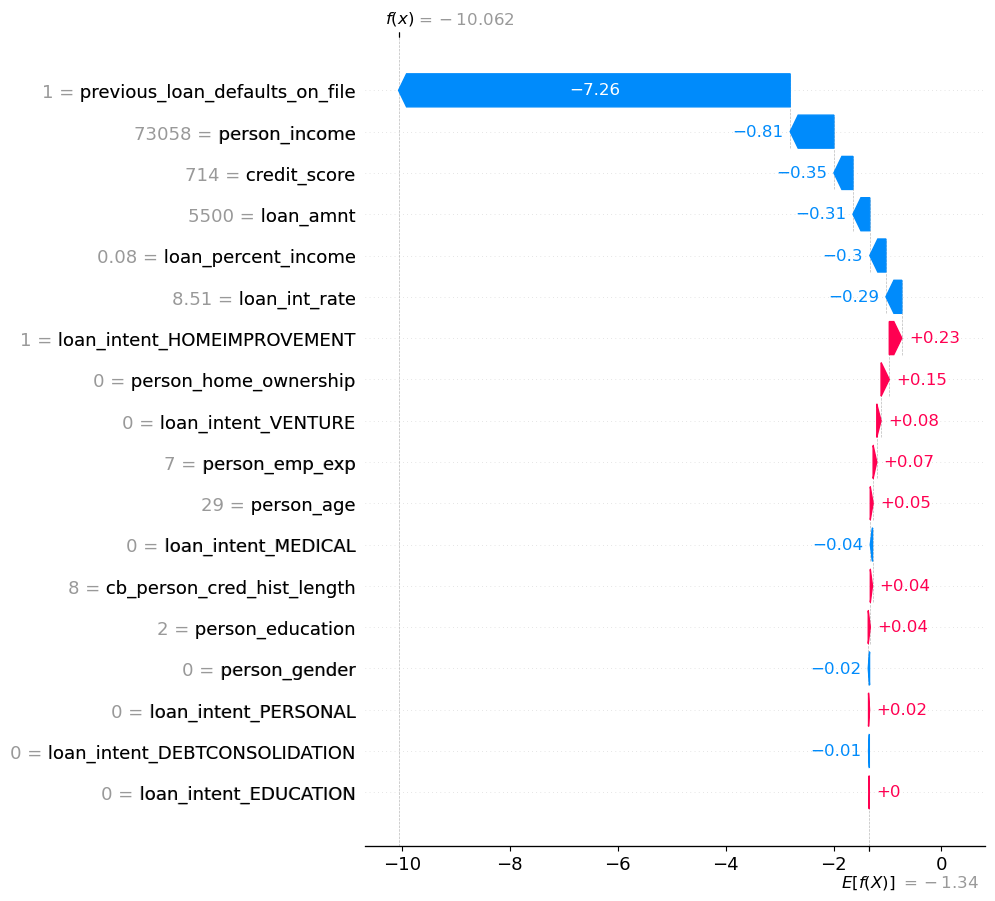

In [146]:
shap.plots.waterfall(shap_values[sample_ind], max_display=99)

The game theory concept we described earlier can be compared to the waterfall plot above. 

We start at bottom-right with -1.34 as base. We add the featzre loan_intent_EDUCATION and stick at the same place, because it has no impact. Then we add the next feature... and the next... and... finally we see that previous_loan_defaults_on_file has the greatest impact (biggest arrow).

This means that the most important question for the bank is: "Did this person already once fail to pay back a loan?"

Since the dataset mainly contains entries with people who indeed failed to pay back a loan, this feature is considered to be very negative in general with a value of -7.26.

However, if a particular user states that he hadn't any loan defaults yet, then the SHAP value would be very positive instead. (-7.26 is just the average expectation.)

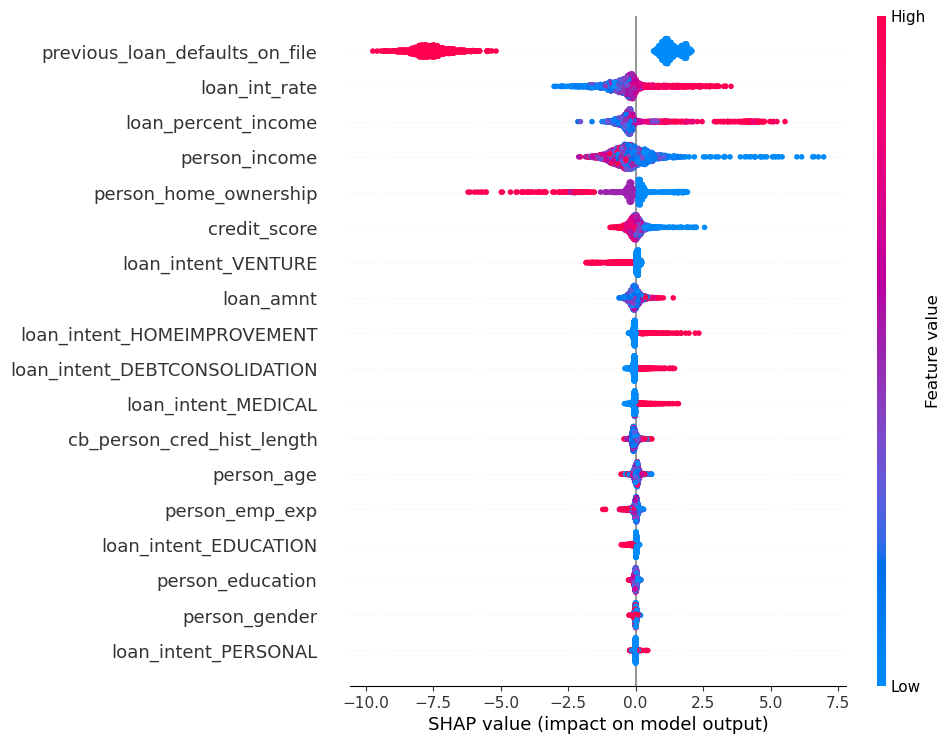

In [147]:
shap.plots.beeswarm(shap_values, max_display=99)

For the beeswarm plot above, we can see that when users state that they (in contrast to the average) did not have any loan defaults, the shap value jumps from approx. -7.5 to approx. 2.

This is good, but "2" is not very high. The bank will not shout "YEAH JACKPOT!!" just because a client says that he didn't default a loan in his history yet. Instead, a way more convincing point would be for the user to state to have a very low income. (Even though this highly depends on the combination with other factirs as can be seen in how flat the blue line is)

More sample plots can be seen below...

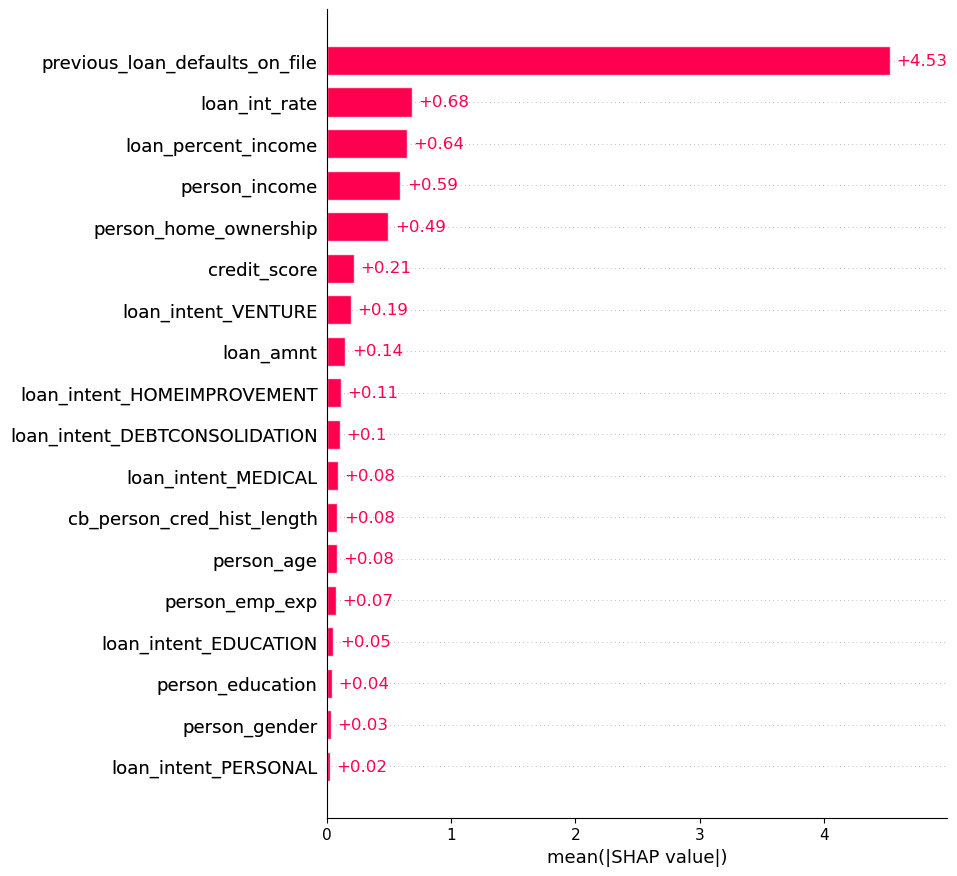

In [148]:
shap.plots.bar(shap_values, max_display=99)

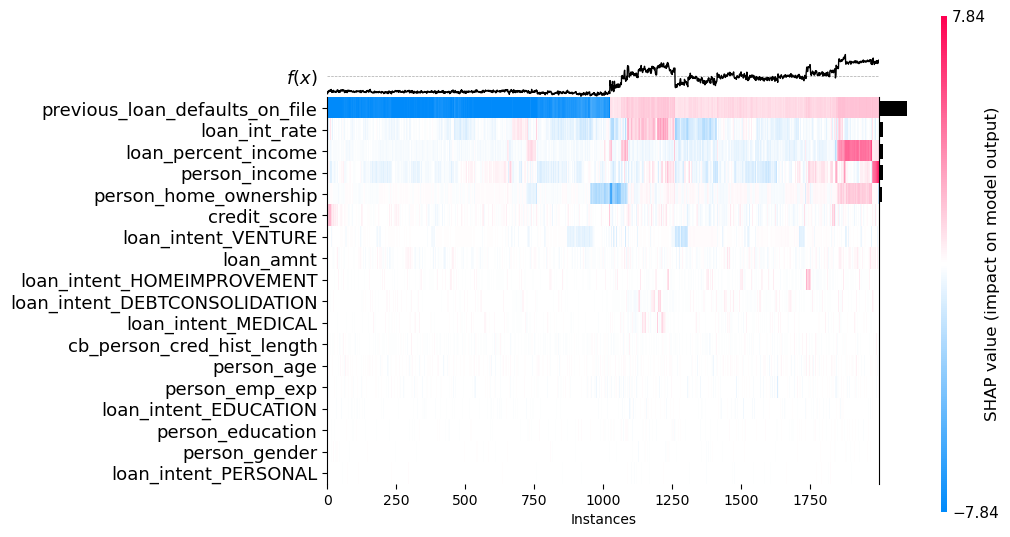

<Axes: xlabel='Instances'>

In [149]:
shap.plots.heatmap(shap_values, max_display=99)

In [150]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values, data100)